<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/Sonia_LondonBikeSharing_borrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install gdown
#!pip install tensorflow-gpu

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

In [ ]:
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/london_merged.csv')

In [ ]:
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [ ]:
data.shape

(17414, 10)

Vemos que tenemos una cantidad bastante buena de muestras.

Las variables son:

"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday

"isweekend" - boolean field - 1 if the day is weekend

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# EDA - Exploratory Data Analysis

In [ ]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [ ]:
data.isnull().values.sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


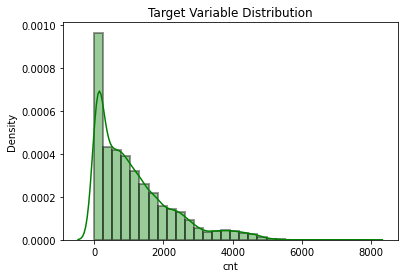

In [ ]:
plt.figure()
sns.distplot(data[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution')
plt.show()

In [ ]:
#convertir "timestamp" a formato datatime para poder separar la información en variables
#data['timestamp'] = pd.to_datetime(data.iloc['timestamp'])

data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data["year"] = data['timestamp'].dt.year #años
data["month"] = data['timestamp'].dt.month #meses
data["day_of_month"] = data['timestamp'].dt.day #día del mes
data["day_of_week"] = data['timestamp'].dt.weekday #dia de la semana
data["hour"] = data['timestamp'].dt.hour #horas
data.head()
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year

In [ ]:
#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values

In [ ]:
data.head(4)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year
timestamp,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1,2015
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1,2015
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1,2015
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1,2015


In [ ]:
data.shape[0]

17414

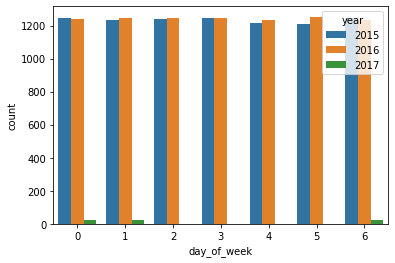

In [ ]:
sns.countplot(x="day_of_week", hue="year", data=data) 

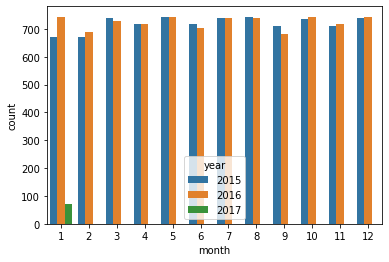

In [ ]:
sns.countplot(x="month", hue="year", data=data)

In [ ]:
# vemos que tenemos datos de los años 2015 y 2016 completos
# y del año 2017 solo diponemos de un mes.

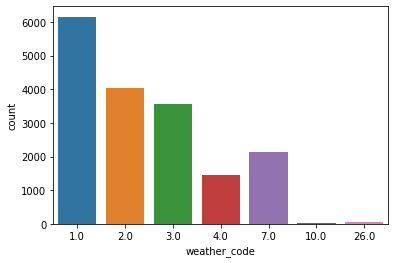

In [ ]:
sns.countplot(x="weather_code", data=data)

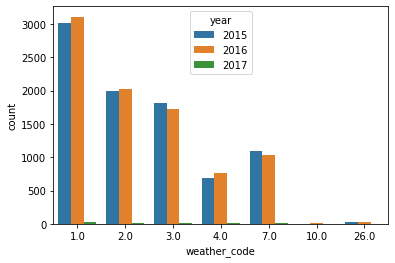

In [ ]:
sns.countplot(x="weather_code", hue = 'year', data=data)

In [ ]:
#como es de esperar los días con un tiempo más soleado se utilizan más las 
#bicicletas, como es de esperar.

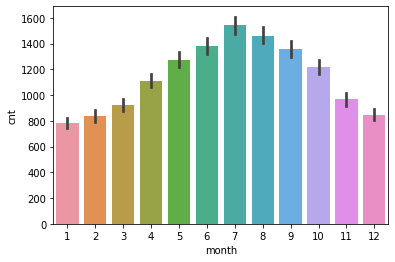

In [ ]:
sns.barplot(x="month", y="cnt", data=data) #ojo, en enero tenemos más datos, quitarlo

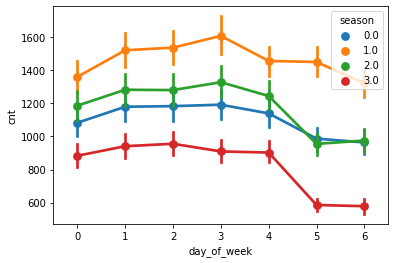

In [ ]:
sns.pointplot(data=data, x="day_of_week", y="cnt", hue="season")

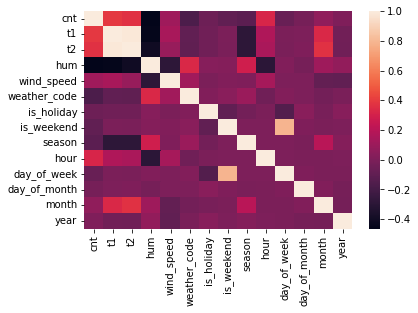

In [ ]:
sns.heatmap(data.corr())

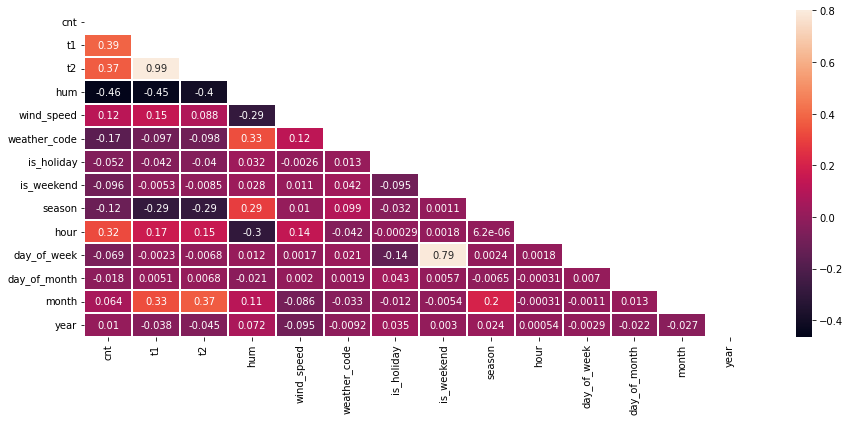

In [ ]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1);

In [ ]:
#como es normal t1 y t2 están estrechamente correlacionadas
#además "is_weekend" (fin de semana) y "day_of_week" también están 
#bastante corelacionadas, como es normal.

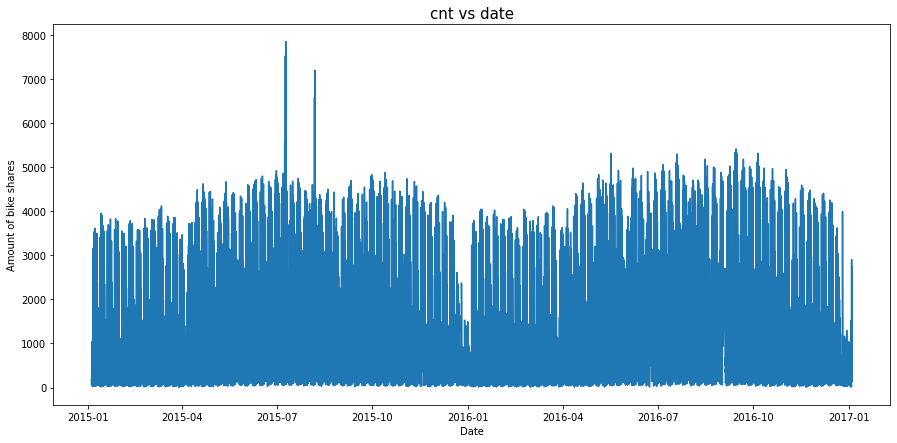

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.lineplot(data=data,x="timestamp",y="cnt")
ax.set_title("cnt vs date", fontsize=15)
ax.set_xlabel("Date", fontsize=10)
ax.set_ylabel('Amount of bike shares', fontsize=10)
plt.show()

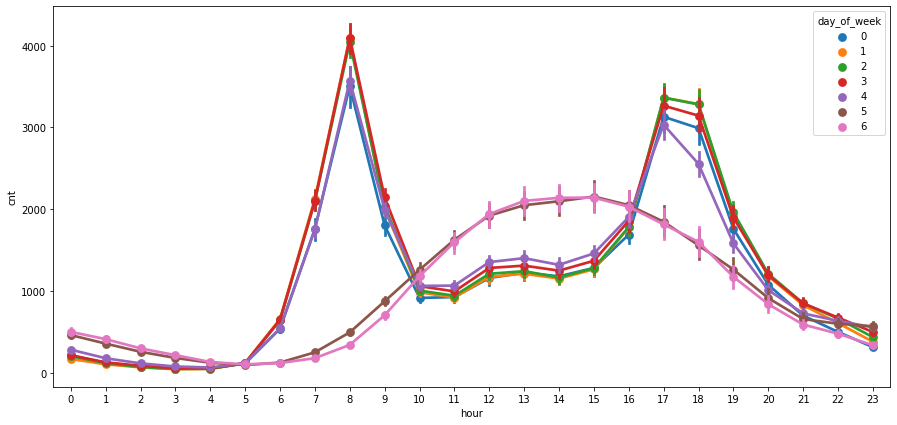

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='day_of_week', data=data)

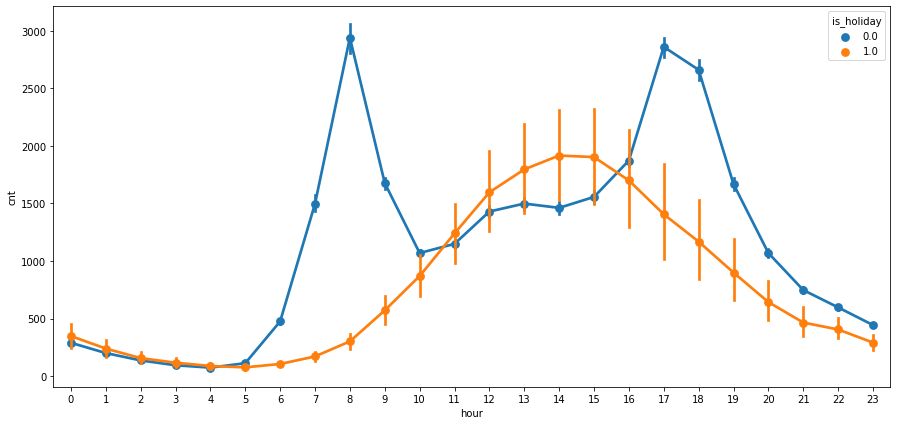

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=data)

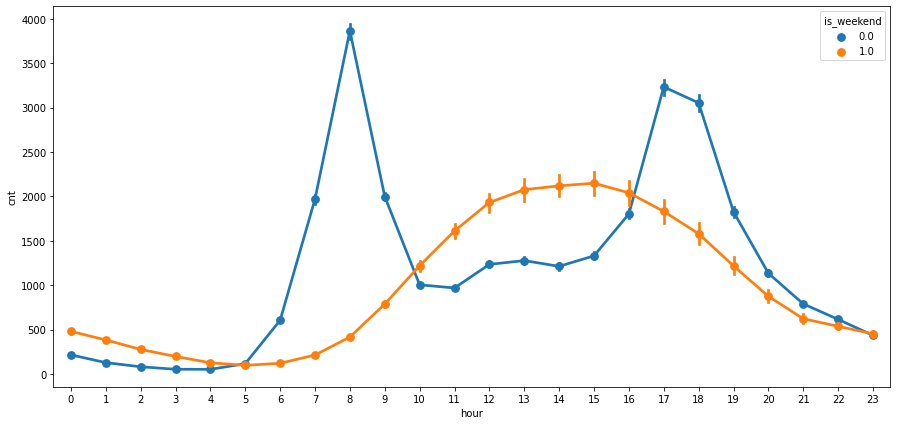

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_weekend', data=data)

In [ ]:
#vemos claramente que entre semana la gente se mueve en bicicleta con mayor frecuencia alrededor de las 8 y alrededor de las 18
#en cambio el fin de semana, se utilizan menos y además, los valores están más dispersos,
#encontrando mayor frecuencia de uso al medio dia.

In [ ]:
'''
# interpolate weather, temp, atemp, humidity, windspeed
all_df["weather"] = all_df["weather"].interpolate(method='time').apply(np.round)
all_df["temp"] = all_df["temp"].interpolate(method='time')
all_df["atemp"] = all_df["atemp"].interpolate(method='time')
all_df["humidity"] = all_df["humidity"].interpolate(method='time').apply(np.round)
all_df["windspeed"] = all_df["windspeed"].interpolate(method='time')
'''

'\n# interpolate weather, temp, atemp, humidity, windspeed\nall_df["weather"] = all_df["weather"].interpolate(method=\'time\').apply(np.round)\nall_df["temp"] = all_df["temp"].interpolate(method=\'time\')\nall_df["atemp"] = all_df["atemp"].interpolate(method=\'time\')\nall_df["humidity"] = all_df["humidity"].interpolate(method=\'time\').apply(np.round)\nall_df["windspeed"] = all_df["windspeed"].interpolate(method=\'time\')\n'

In [ ]:
# Mas preproceso 
#data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Preprocessing

In [ ]:
data_final = data[['t1',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'cnt']]

 #si no tengo indexado timestamp deberé añadirlo como "label"

In [ ]:
data_final.head()

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
timestamp,,,,,,,,
2015-01-04 00:00:00,3.0,93.0,6.0,3.0,0.0,1.0,3.0,182
2015-01-04 01:00:00,3.0,93.0,5.0,1.0,0.0,1.0,3.0,138
2015-01-04 02:00:00,2.5,96.5,0.0,1.0,0.0,1.0,3.0,134
2015-01-04 03:00:00,2.0,100.0,0.0,1.0,0.0,1.0,3.0,72
2015-01-04 04:00:00,2.0,93.0,6.5,1.0,0.0,1.0,3.0,47


## train / test

In [ ]:
train_split = 0.9
num_data = len(data_final)
num_train = int(train_split * num_data)
num_train

num_test = num_data - num_train
num_test

train, test = data_final.iloc[0:num_train], data_final.iloc[(num_train):len(data_final)]
print(data_final.shape, train.shape, test.shape)

(17414, 8) (15672, 8) (1742, 8)


In [ ]:
'''
punto_corte = int(len(data_final)*train_split)
time_steps = 10
fechas = []
fechas_train = timestamp[time_steps:punto_corte] # elimino los lookback primeros al tener NANs

fechas_test  = fechas[punto_corte:]
'''

'\npunto_corte = int(len(data_final)*train_split)\ntime_steps = 10\nfechas = []\nfechas_train = timestamp[time_steps:punto_corte] #\xa0elimino los lookback primeros al tener NANs\n\nfechas_test  = fechas[punto_corte:]\n'

In [ ]:
int(train.shape[0]) + int(test.shape[0])

17414

In [ ]:
#Escalamos datos para un mejor rendimiento de la red y un menor coste comuptacional

In [ ]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [ ]:
cnt_transformer = RobustScaler()
cnt_transformer = cnt_transformer.fit(train[['cnt']])
train['cnt'] = cnt_transformer.transform(train[['cnt']])
test['cnt'] = cnt_transformer.transform(test[['cnt']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
#cnt_transformer = scaler.fit_transform(train[['cnt']]) 

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train.tail(10)

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
15662,-0.3750,0.425,-0.818182,1.0,0.0,1.0,2.0,0.074936
15663,-0.3750,0.425,-0.909091,2.0,0.0,1.0,2.0,0.069211
15664,-0.5000,0.675,-1.000000,3.0,0.0,1.0,2.0,0.058142
15665,-0.5000,0.675,-1.090909,3.0,0.0,1.0,2.0,0.054580
15666,-0.5625,0.825,-0.909091,2.0,0.0,1.0,2.0,0.045165
15667,-0.6250,0.825,-0.818182,2.0,0.0,1.0,2.0,0.027608
15668,-0.6250,0.975,-0.818182,2.0,0.0,1.0,2.0,0.019084
15669,-0.6250,0.675,-1.000000,3.0,0.0,1.0,2.0,0.013613
15670,-0.6250,0.825,-0.772727,3.0,0.0,1.0,2.0,0.013613
15671,-0.6875,0.825,-0.818182,1.0,0.0,1.0,2.0,0.022010


In [ ]:
print(train.cnt.max())
print(train.cnt.min())

1.0
0.0


In [ ]:
test.head(20)

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,cnt
15672,-0.6250,0.675,-0.818182,2.0,0.0,1.0,2.0,0.062728
15673,-0.4375,0.275,-0.454545,2.0,0.0,1.0,2.0,0.148725
15674,-0.3125,0.025,0.000000,3.0,0.0,1.0,2.0,0.273169
15675,-0.1250,-0.200,0.636364,2.0,0.0,1.0,2.0,0.382639
15676,-0.1250,-0.325,0.818182,2.0,0.0,1.0,2.0,0.436463
15677,-0.0625,-0.300,0.818182,2.0,0.0,1.0,2.0,0.490894
15678,0.0000,-0.525,0.909091,2.0,0.0,1.0,2.0,0.443950
15679,0.0000,-0.425,0.727273,2.0,0.0,1.0,2.0,0.485026
15680,-0.1250,-0.325,0.727273,2.0,0.0,1.0,2.0,0.416835
15681,-0.1250,-0.200,0.818182,3.0,0.0,1.0,2.0,0.367665


In [ ]:
print(test.cnt.max())
print(test.cnt.min())

1.0
0.0


In [ ]:
#time_steps = lag = # lag is the number of previous values to consider for predicting next one
def create_dataset(X, y, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values # slice of "lag" length starting at i
        dataX.append(v)        
        dataY.append(y.iloc[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [ ]:
train.cnt

timestamp
2015-01-04 00:00:00   -0.464876
2015-01-04 01:00:00   -0.495179
2015-01-04 02:00:00   -0.497934
2015-01-04 03:00:00   -0.540634
2015-01-04 04:00:00   -0.557851
                         ...   
2016-10-23 03:00:00   -0.440771
2016-10-23 04:00:00   -0.486915
2016-10-23 05:00:00   -0.516529
2016-10-23 06:00:00   -0.516529
2016-10-23 07:00:00   -0.471074
Name: cnt, Length: 15672, dtype: float64

In [ ]:
#time_steps = 10
time_steps = 48

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

#print(X_train.shape, y_train.shape)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# reshape to [samples, time_steps, n_features]

(15624, 48, 8)
(1694, 48, 8)
(15624,)
(1694,)


In [ ]:
print(X_train[-1, 0:]) #10 o 48 time steps y 8 features, var. contexto
print(X_test[-1, 0:]) 

[[-0.375       0.725      -0.27272727  2.          0.          0.
   2.          0.84710744]
 [-0.375       0.725      -0.09090909  2.          0.          0.
   2.          2.33884298]
 [-0.375       0.725       0.          7.          0.          0.
   2.          0.97520661]
 [-0.3125      0.575       0.          7.          0.          0.
   2.          0.2107438 ]
 [-0.1875      0.3         0.18181818  2.          0.          0.
   2.          0.18663912]
 [-0.125       0.175       0.09090909  3.          0.          0.
   2.          0.39807163]
 [ 0.         -0.075      -0.09090909  3.          0.          0.
   2.          0.47933884]
 [ 0.         -0.2         0.          3.          0.          0.
   2.          0.38360882]
 [ 0.0625     -0.425      -0.18181818  3.          0.          0.
   2.          0.44214876]
 [ 0.         -0.075      -0.27272727  3.          0.          0.
   2.          0.86707989]
 [ 0.         -0.075      -0.54545455  3.          0.          0.
   2

In [ ]:
'''
print(X_train[5])
print(X_train[-5])
'''
print(y_train[5])
print(y_train[-5]) #cnt escalado

0.009414758269720101
0.027608142493638677


# (ESTE NO SALE BIEN) LSTM con los datos de 'cnt' escalados con MinMaxScaler

Este modelo luego lo borraré porque no predice bien, he escalado mal o este métodos no es suficientemente robusto a la distribución de datos que tenemos. 

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))  # input_shape=[time steps, features]
model_0.add(Dense(1))
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_0 = Sequential()
model_0.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
model_0.add(Dense(units = 512, activation = 'relu'))
model_0.add(Dense(units = 1, activation = 'linear'))
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1067008   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,330,177
Trainable params: 1,330,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_0.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_0.fit(X_train, y_train, epochs=20, batch_size=2, verbose=2)

Epoch 1/20
7812/7812 - 154s - loss: 0.0058 - 154s/epoch - 20ms/step
Epoch 2/20
7812/7812 - 148s - loss: 0.0015 - 148s/epoch - 19ms/step
Epoch 3/20
7812/7812 - 149s - loss: 0.0011 - 149s/epoch - 19ms/step
Epoch 4/20
7812/7812 - 148s - loss: 8.5633e-04 - 148s/epoch - 19ms/step
Epoch 5/20
7812/7812 - 148s - loss: 8.0393e-04 - 148s/epoch - 19ms/step
Epoch 6/20
7812/7812 - 148s - loss: 7.4549e-04 - 148s/epoch - 19ms/step
Epoch 7/20
7812/7812 - 149s - loss: 6.9382e-04 - 149s/epoch - 19ms/step
Epoch 8/20
7812/7812 - 148s - loss: 6.3393e-04 - 148s/epoch - 19ms/step
Epoch 9/20
7812/7812 - 147s - loss: 6.2448e-04 - 147s/epoch - 19ms/step
Epoch 10/20
7812/7812 - 148s - loss: 6.0991e-04 - 148s/epoch - 19ms/step
Epoch 11/20
7812/7812 - 147s - loss: 5.4508e-04 - 147s/epoch - 19ms/step
Epoch 12/20
7812/7812 - 146s - loss: 5.2565e-04 - 146s/epoch - 19ms/step
Epoch 13/20
7812/7812 - 146s - loss: 5.4544e-04 - 146s/epoch - 19ms/step
Epoch 14/20
7812/7812 - 146s - loss: 5.0086e-04 - 146s/epoch - 19ms/step

In [ ]:
# make predictions

y_pred_test = model_0.predict(X_test)
y_pred_train = model_0.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


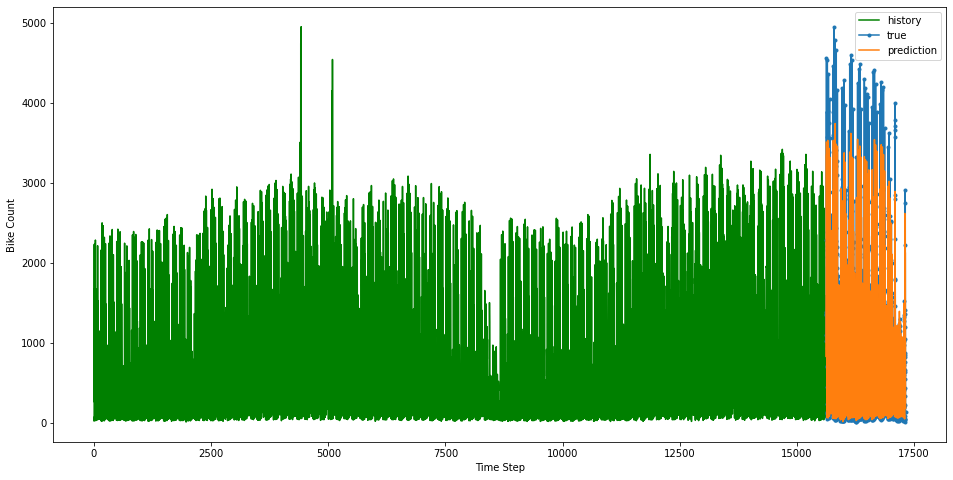

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_train_inv.shape

(1, 15624)

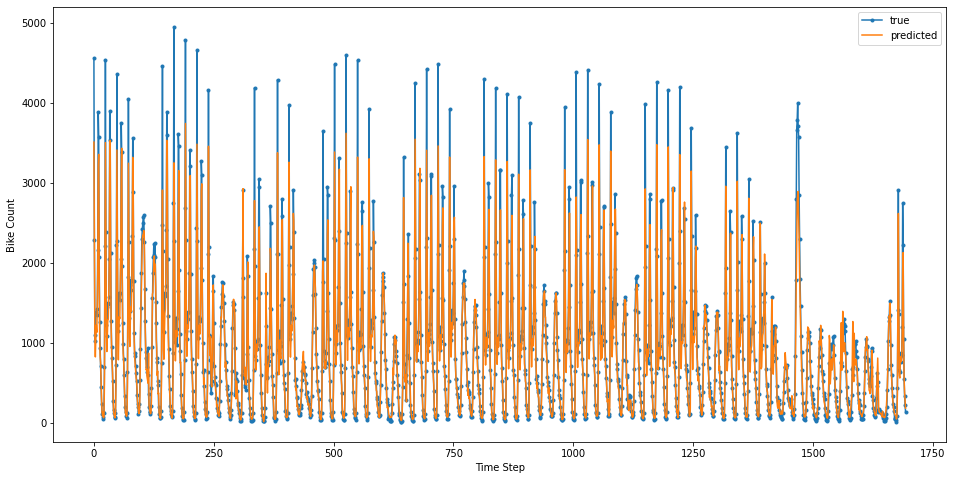

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_pred_test_inv

array([[3507.7112 ],
       [2351.9456 ],
       [1064.6718 ],
       ...,
       [ 381.69595],
       [ 289.48877],
       [ 181.67502]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 96.50 RMSE
Test Score: 234.93 RMSE


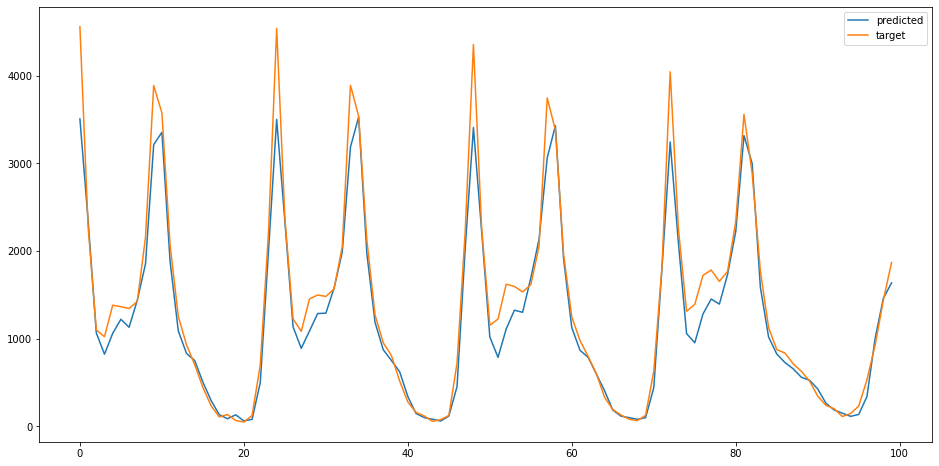

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

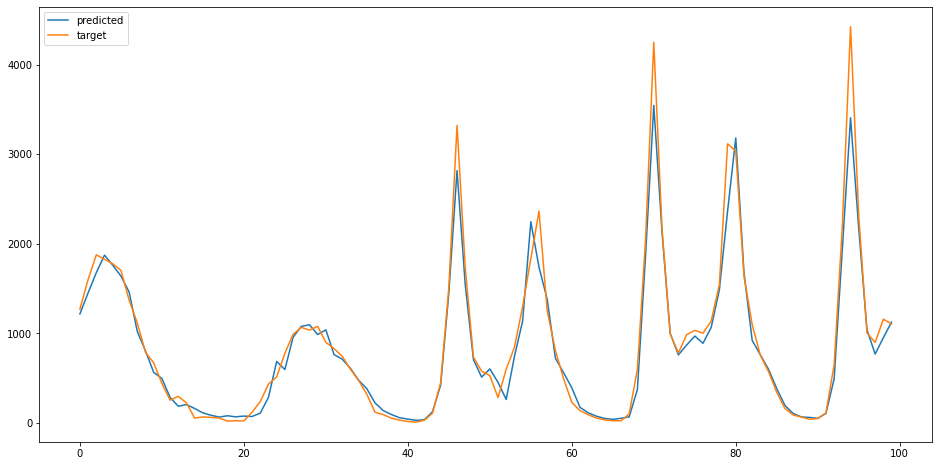

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# LSTM 2 con datos 'cnt' escalados con RobustScaler

Modelo LSTM con dropout. Por ahora entreno con 10 epochs para ver que tal, ya que con los recursos computacionales disponibles se tarda mucho tiempo en entrenar. 

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(rate=0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(loss='mean_squared_error', optimizer='Adam')
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               70144     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=1)

Epoch 1/10
14061/14061 [==============================] - 193s 9ms/step - loss: 0.0826 - val_loss: 0.0418
Epoch 2/10
14061/14061 [==============================] - 129s 9ms/step - loss: 0.0326 - val_loss: 0.0217
Epoch 3/10
14061/14061 [==============================] - 129s 9ms/step - loss: 0.0271 - val_loss: 0.0284
Epoch 4/10
14061/14061 [==============================] - 130s 9ms/step - loss: 0.0247 - val_loss: 0.0193
Epoch 5/10
14061/14061 [==============================] - 130s 9ms/step - loss: 0.0231 - val_loss: 0.0223
Epoch 6/10
14061/14061 [==============================] - 129s 9ms/step - loss: 0.0217 - val_loss: 0.0199
Epoch 7/10
14061/14061 [==============================] - 130s 9ms/step - loss: 0.0207 - val_loss: 0.0180
Epoch 8/10
14061/14061 [==============================] - 130s 9ms/step - loss: 0.0201 - val_loss: 0.0176
Epoch 9/10
14061/14061 [==============================] - 130s 9ms/step - loss: 0.0191 - val_loss: 0.0279
Epoch 10/10
14061/14061 [=====================

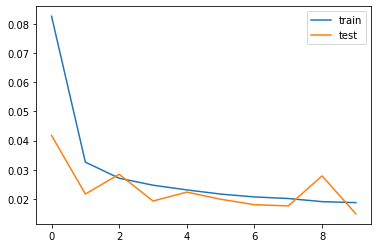

In [ ]:
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend();

In [ ]:
# make predictions

y_pred_test = model_lstm.predict(X_test)
y_pred_train = model_lstm.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = cnt_transformer.inverse_transform(y_pred_test)
y_pred_train_inv = cnt_transformer.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


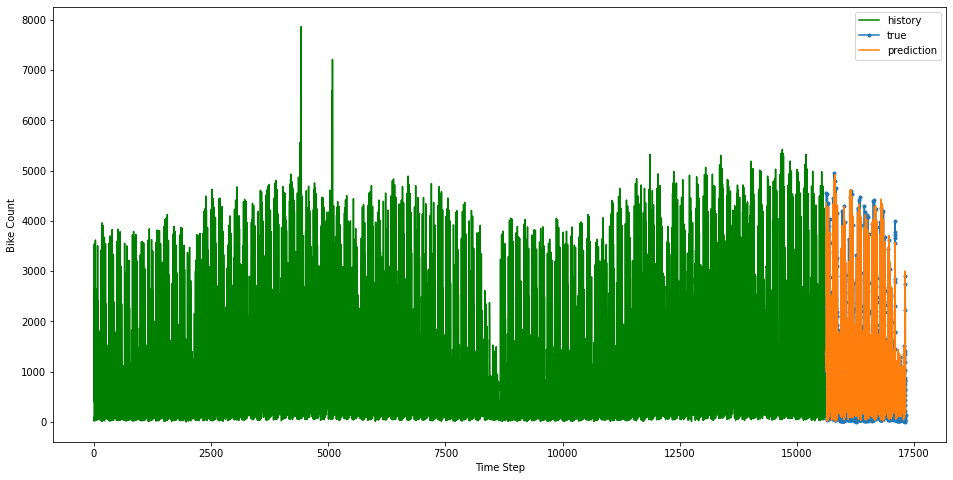

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

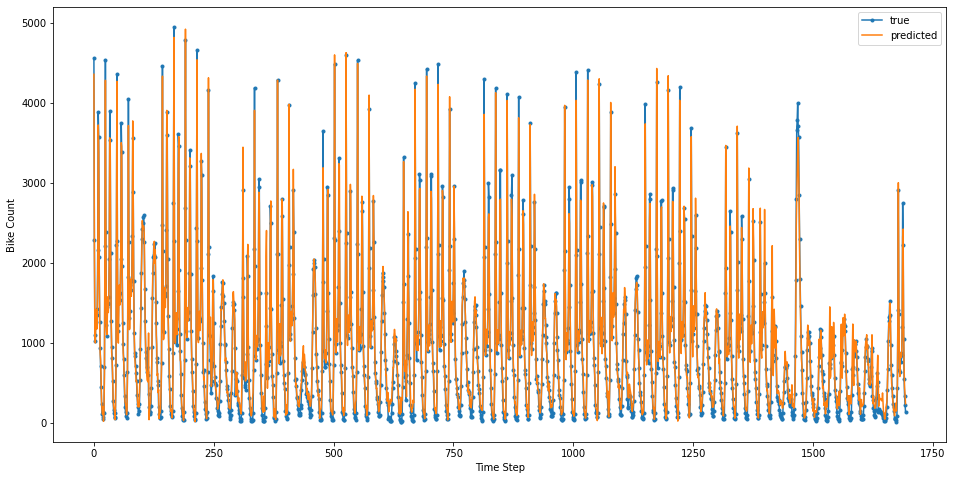

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 166.61 RMSE
Test Score: 148.71 RMSE


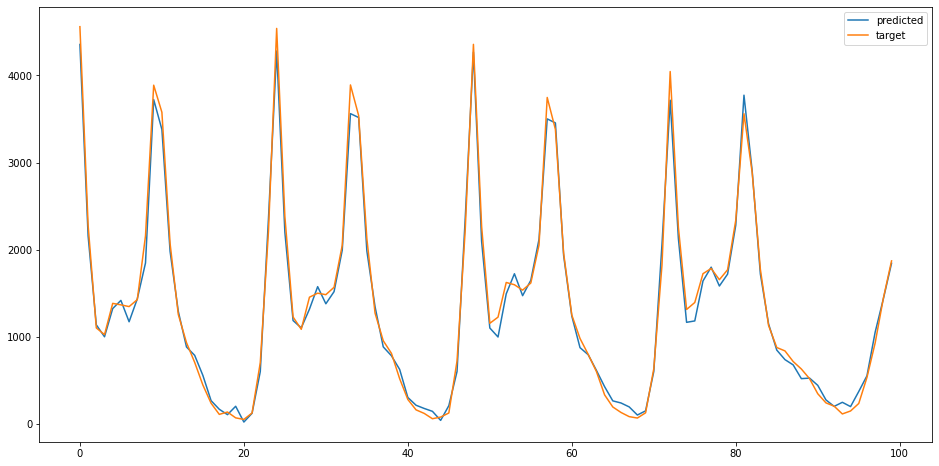

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

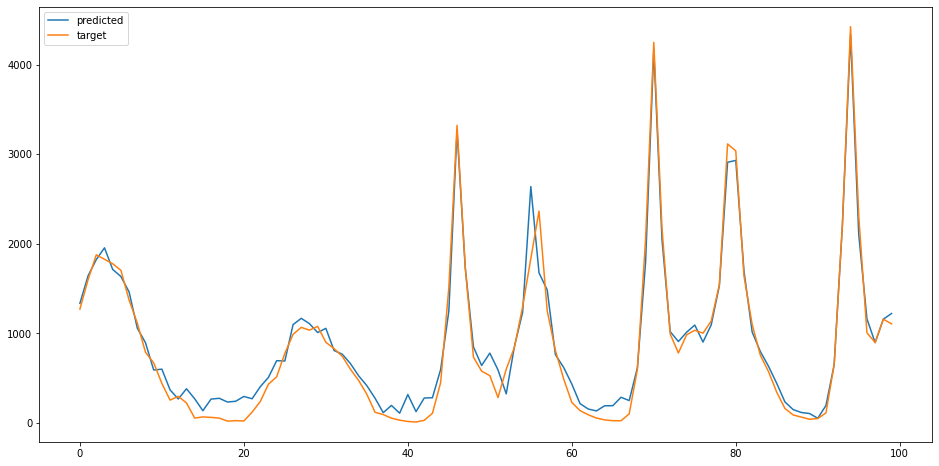

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# LSTM BIDIRECTIONAL

## Escalando 'cnt' como RobustScaler

In [ ]:
model_bid = Sequential()
model_bid.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]))))
model_bid.add(Dropout(rate=0.2))
model_bid.add(Dense(units=1))
model_bid.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history_bid = model_bid.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=1)

Epoch 1/10
14061/14061 [==============================] - 277s 19ms/step - loss: 0.0830 - val_loss: 0.0492
Epoch 2/10
14061/14061 [==============================] - 271s 19ms/step - loss: 0.0333 - val_loss: 0.0221
Epoch 3/10
14061/14061 [==============================] - 270s 19ms/step - loss: 0.0276 - val_loss: 0.0240
Epoch 4/10
14061/14061 [==============================] - 270s 19ms/step - loss: 0.0238 - val_loss: 0.0174
Epoch 5/10
14061/14061 [==============================] - 273s 19ms/step - loss: 0.0222 - val_loss: 0.0173
Epoch 6/10
14061/14061 [==============================] - 277s 20ms/step - loss: 0.0214 - val_loss: 0.0166
Epoch 7/10
14061/14061 [==============================] - 276s 20ms/step - loss: 0.0204 - val_loss: 0.0250
Epoch 8/10
14061/14061 [==============================] - 270s 19ms/step - loss: 0.0197 - val_loss: 0.0214
Epoch 9/10
14061/14061 [==============================] - 268s 19ms/step - loss: 0.0189 - val_loss: 0.0222
Epoch 10/10
14061/14061 [============

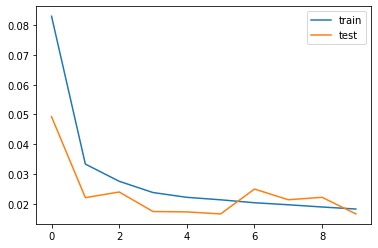

In [ ]:
plt.plot(history_bid.history['loss'], label='train')
plt.plot(history_bid.history['val_loss'], label='test')
plt.legend();

In [ ]:
# make predictions

y_pred_test = model_bid.predict(X_test)
y_pred_train = model_bid.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = cnt_transformer.inverse_transform(y_pred_test)
y_pred_train_inv = cnt_transformer.inverse_transform(y_pred_train)
#y_test_pred_inv = scaler.inverse_transform(y_pred_test)
#y_train_pred_inv = scaler.inverse_transform(y_pred_train)


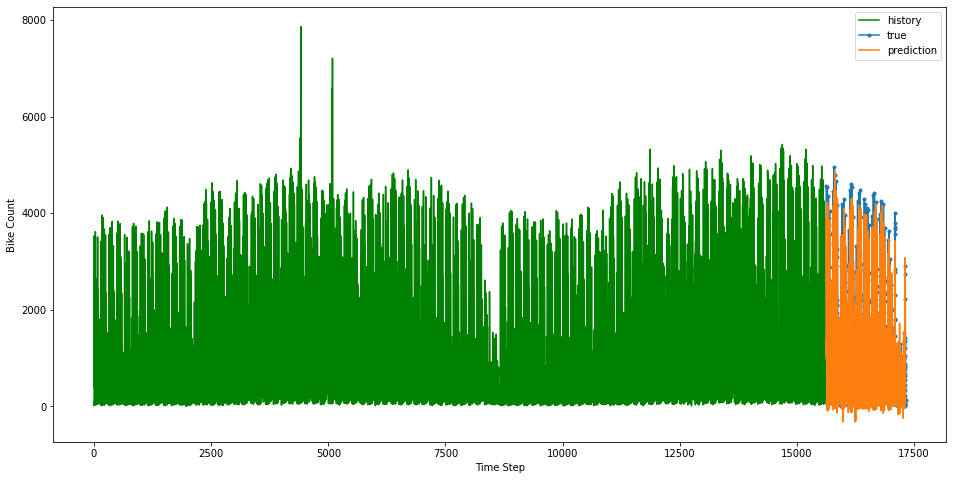

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

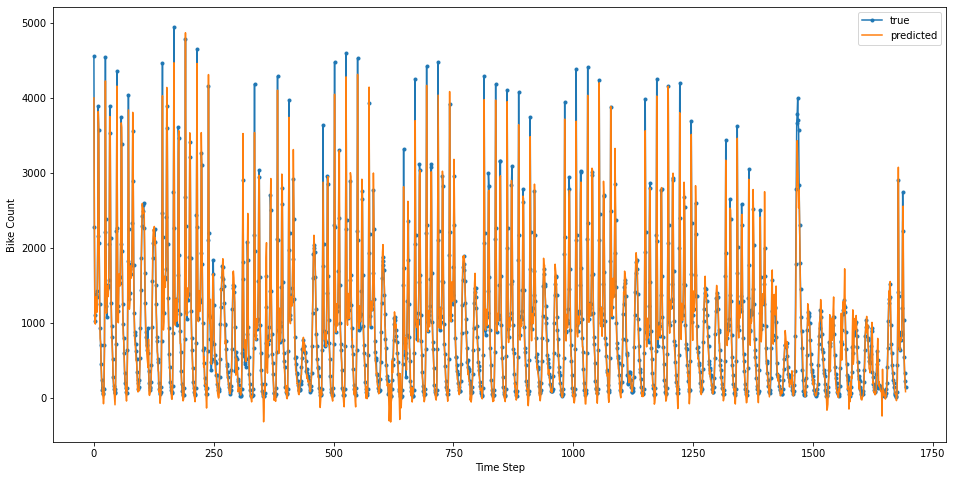

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 173.71 RMSE
Test Score: 151.02 RMSE


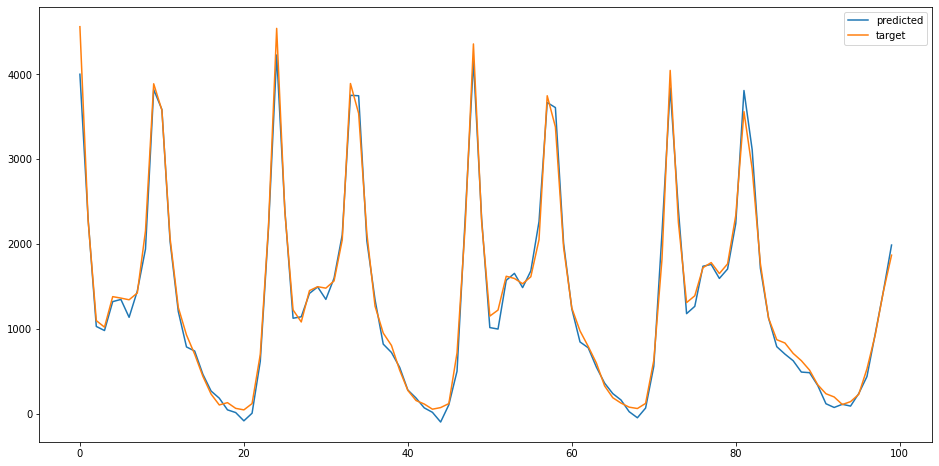

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

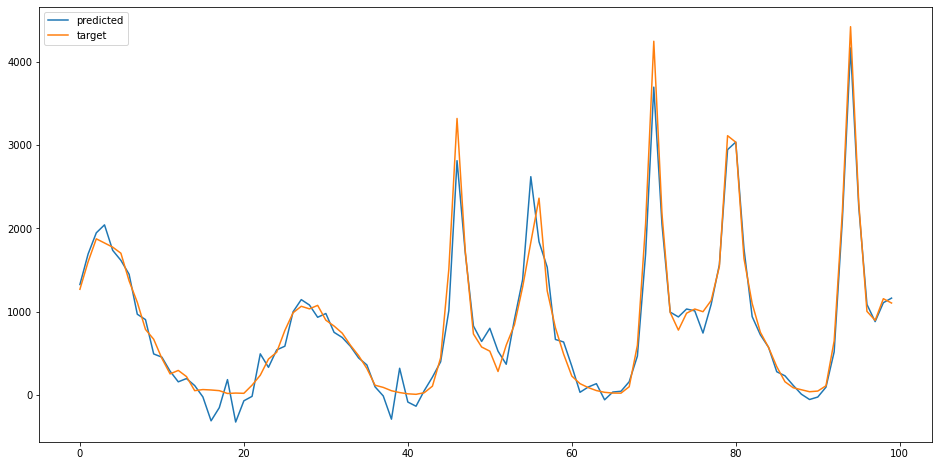

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

## Escalando 'cnt' como MinMaxScaler

In [ ]:
'''
VISUALIZACIONES CON MinMaxScaler 
'''

# make predictions

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = scaler.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)

'''
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
'''

'\ntrainPredict = scaler.inverse_transform(trainPredict)\ntrainY = scaler.inverse_transform([y_train])\ntestPredict = scaler.inverse_transform(testPredict)\ntestY = scaler.inverse_transform([y_test])\n'

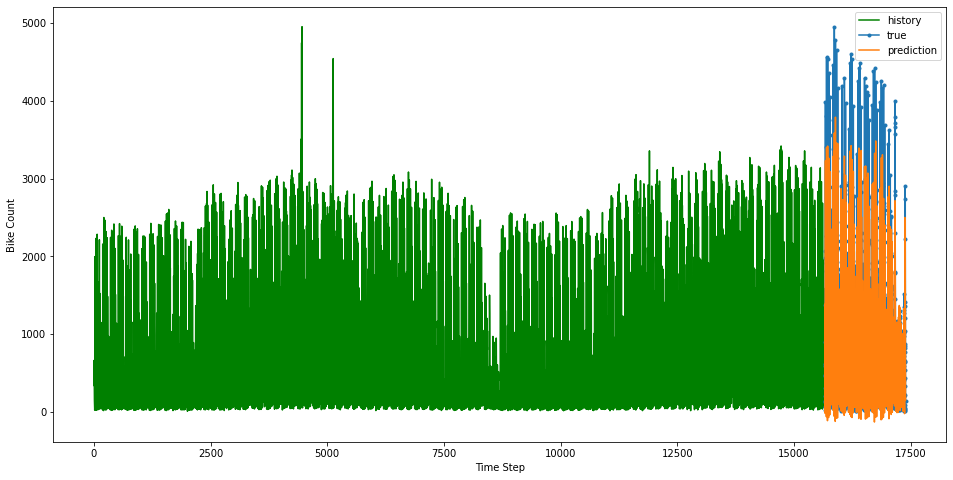

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

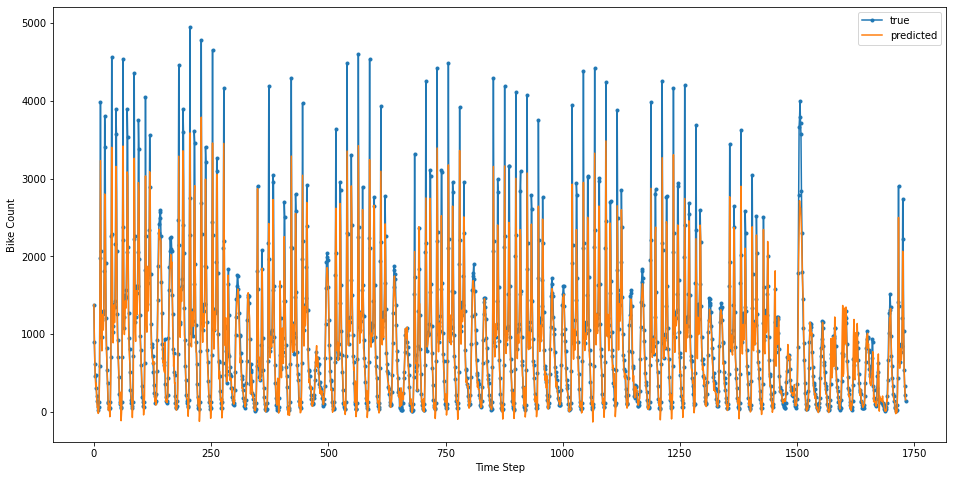

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
y_pred_test_inv

array([[1380.4135 ],
       [ 936.95795],
       [ 610.78827],
       ...,
       [ 354.1295 ],
       [ 238.64658],
       [ 157.14285]], dtype=float32)

In [ ]:
y_test_inv

array([[1376.,  894.,  615., ...,  337.,  224.,  139.]])

In [ ]:
y_pred_test_inv

array([[1380.4135 ],
       [ 936.95795],
       [ 610.78827],
       ...,
       [ 354.1295 ],
       [ 238.64658],
       [ 157.14285]], dtype=float32)

In [ ]:
y_pred_test_inv.flatten()

array([1380.4135 ,  936.95795,  610.78827, ...,  354.1295 ,  238.64658,
        157.14285], dtype=float32)

In [ ]:
y_pred_test_inv.shape

(1732, 1)

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 103.15 RMSE
Test Score: 267.44 RMSE


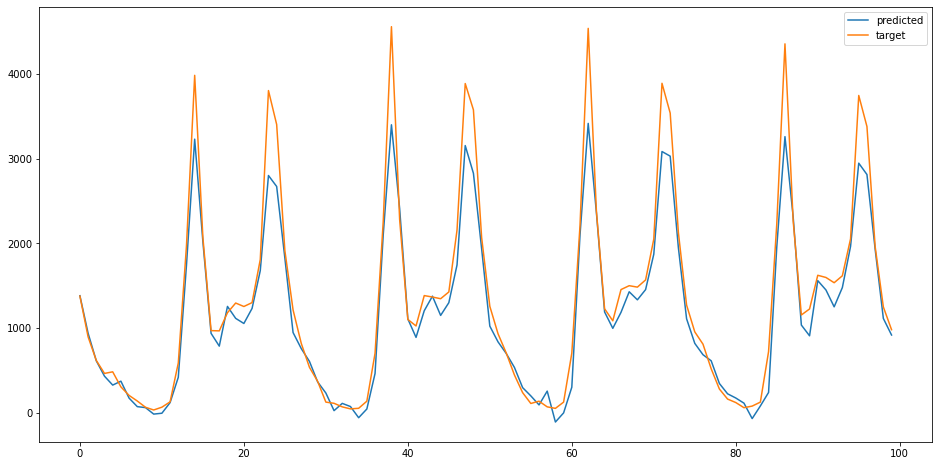

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

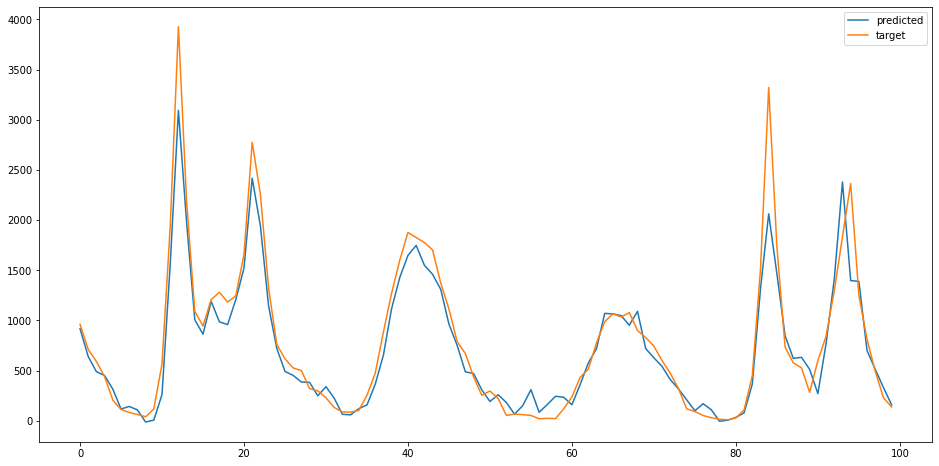

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()

# GRU

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dense(units = 512, activation = 'relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(units = 1, activation = 'linear'))
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model_gru.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.01))

model_gru.compile(loss='mean_squared_error', optimizer='adam')
history = model_gru.fit(X_train, y_train, epochs=20, batch_size=2, verbose=2)

Epoch 1/20
7812/7812 - 78s - loss: 0.0716 - 78s/epoch - 10ms/step
Epoch 2/20
7812/7812 - 71s - loss: 0.0349 - 71s/epoch - 9ms/step
Epoch 3/20
7812/7812 - 72s - loss: 0.0290 - 72s/epoch - 9ms/step
Epoch 4/20
7812/7812 - 72s - loss: 0.0264 - 72s/epoch - 9ms/step
Epoch 5/20
7812/7812 - 71s - loss: 0.0238 - 71s/epoch - 9ms/step
Epoch 6/20
7812/7812 - 72s - loss: 0.0226 - 72s/epoch - 9ms/step
Epoch 7/20
7812/7812 - 72s - loss: 0.0217 - 72s/epoch - 9ms/step
Epoch 8/20
7812/7812 - 71s - loss: 0.0213 - 71s/epoch - 9ms/step
Epoch 9/20
7812/7812 - 71s - loss: 0.0205 - 71s/epoch - 9ms/step
Epoch 10/20
7812/7812 - 71s - loss: 0.0200 - 71s/epoch - 9ms/step
Epoch 11/20
7812/7812 - 71s - loss: 0.0201 - 71s/epoch - 9ms/step
Epoch 12/20
7812/7812 - 71s - loss: 0.0199 - 71s/epoch - 9ms/step
Epoch 13/20
7812/7812 - 71s - loss: 0.0191 - 71s/epoch - 9ms/step
Epoch 14/20
7812/7812 - 71s - loss: 0.0188 - 71s/epoch - 9ms/step
Epoch 15/20
7812/7812 - 71s - loss: 0.0193 - 71s/epoch - 9ms/step
Epoch 16/20
7812/7

KeyError: ignored

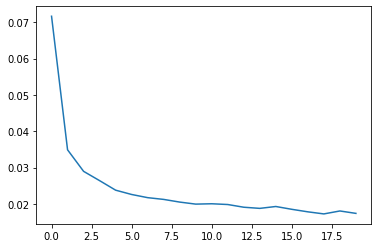

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
# make predictions

y_pred_test = model_gru.predict(X_test)
y_pred_train = model_gru.predict(X_train)

In [ ]:
# invert scaling

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1)) #flatten() creo que hace lo mismo
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_test_inv = cnt_transformer.inverse_transform(y_pred_test)
y_pred_train_inv = cnt_transformer.inverse_transform(y_pred_train)

'''
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
'''

'\ntrainPredict = scaler.inverse_transform(trainPredict)\ntrainY = scaler.inverse_transform([y_train])\ntestPredict = scaler.inverse_transform(testPredict)\ntestY = scaler.inverse_transform([y_test])\n'

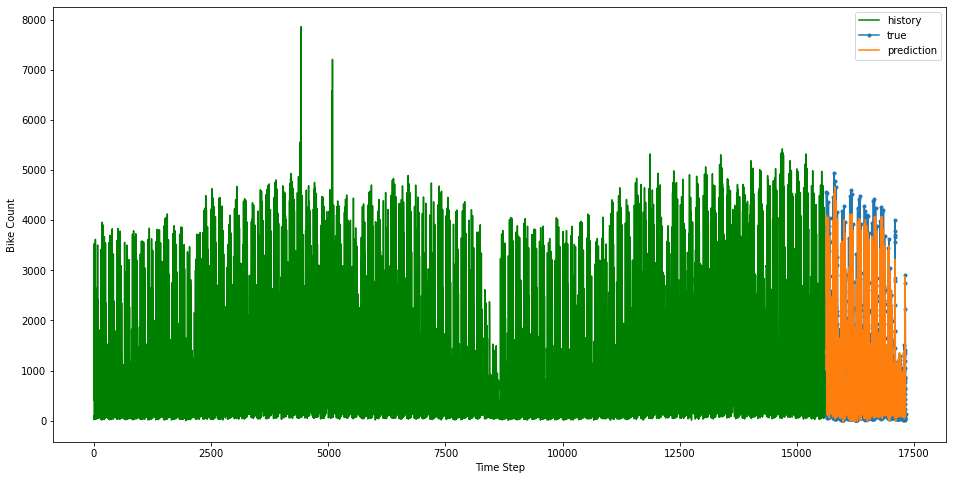

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_test_inv.flatten(), label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

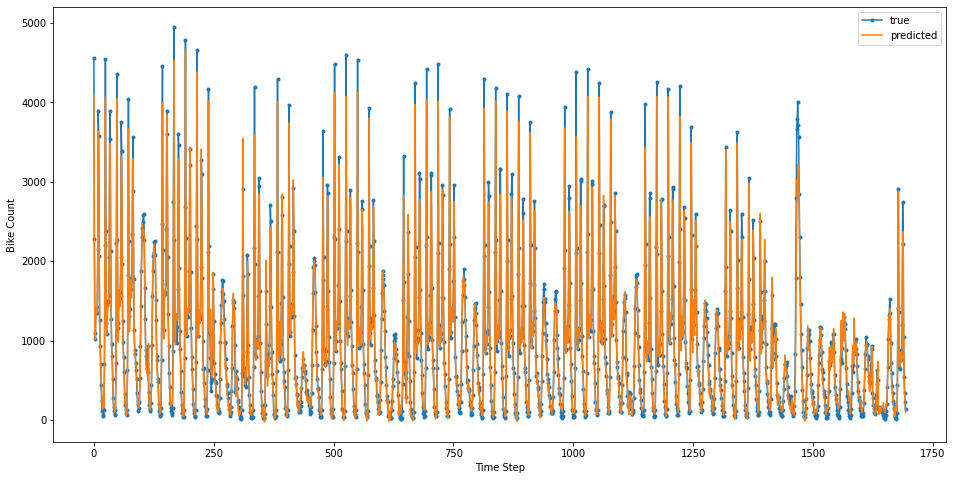

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_test_inv.flatten(), label="predicted")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_inv[0], y_pred_train_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_inv[0], y_pred_test_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 157.17 RMSE
Test Score: 148.73 RMSE


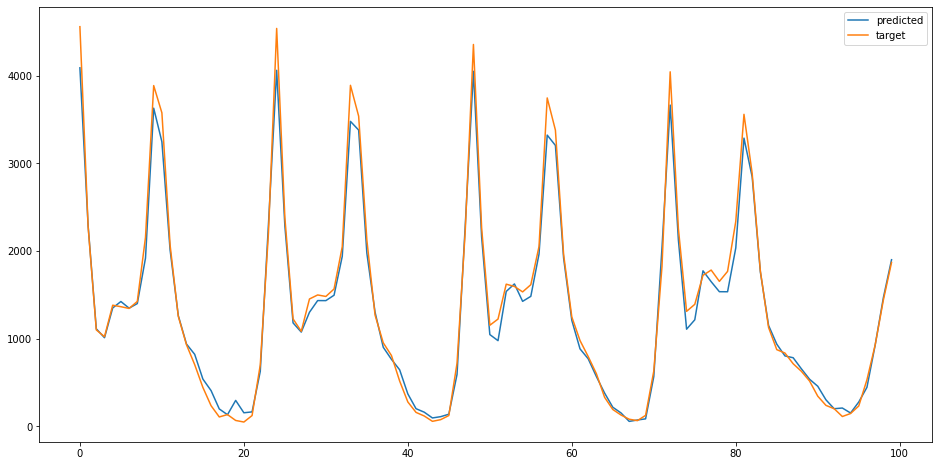

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[0:100], label='predicted')
plt.plot(y_test_inv[0][0:100], label='target')
plt.legend()
plt.show()

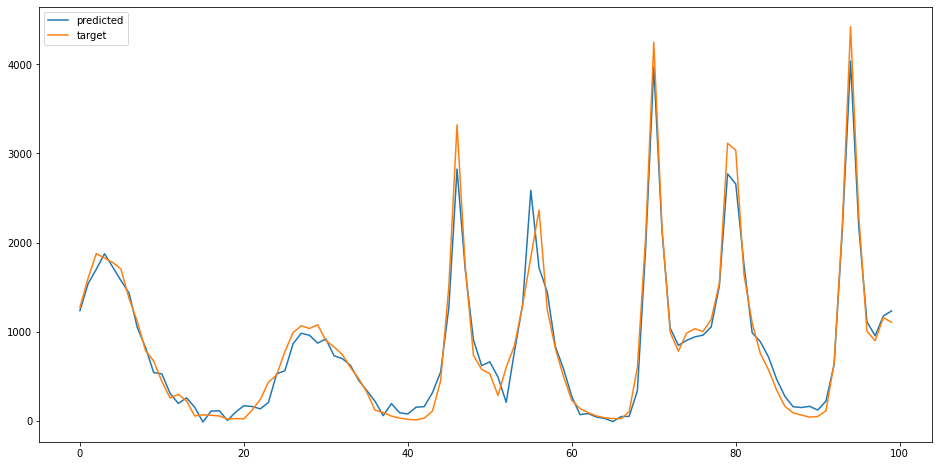

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_pred_test_inv[600:700], label='predicted')
plt.plot(y_test_inv[0][600:700], label='target')
plt.legend()
plt.show()